Star-Dia Source Correlation
===

The goal of this notebook is to understand the distribution of Dia sources surrounding bright stars. The input to this is the output from `star_diffim_correlation.py`, which produces an sqlite3 file containing sets of the radii of each Dia source surrounding stars brighter than ~16 (really anything in the UCAC catalog).

In [1]:
%matplotlib inline
from __future__ import print_function, division

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import sqlalchemy
from sqlalchemy.orm import sessionmaker

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10.0, 6.5)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelcolor'] = "#000000"

from star_diffim_correlation import SourceDetectionCorrelation as SDC

In [2]:
engine = sqlalchemy.create_engine('sqlite:///star_diffim.sqlite3')

SessionFactory = sessionmaker()
SessionFactory.configure(bind=engine)
session = SessionFactory()

In [3]:
def make_normalized_histogram(filtered_query, bins):
    H = np.zeros(len(bins) - 1)
    for source in filtered_query:
        source_H, _ = np.histogram(source.dist_array(), bins=bins)
        H += source_H
        
    nstars = filtered_query.count()
    norm = np.pi*bins[1:]**2 - np.pi*bins[:-1]**2
    normalized_H = H/norm/float(nstars)
    return normalized_H


This next code computes the Dia source density histograms in bins of (bright source) magnitude. It is somewhat slow, so it is separated from plotting. Output is in `density_curves`.

In [4]:
radius_bins = np.linspace(0,120,60)
radius_bin_centers = 0.5*(radius_bins[1:] + radius_bins[:-1])

# 60 chips. 0.045 sq deg per chip. 3600**2 sq arcsec per sq deg
# 20e3 detections is what I get from counting on visit 197391
mean_density = 0.3*20e3 / (60 * 0.045) / 3600.0**2

# All the good visits happen to be < 197800
good_visits =  (197367, 197375, 197379, 197388, 197392, 197400, 197404, 197412)

density_bins = [16,15,14,13,12,10,8]
density_curves = []
for bin_start,bin_end in zip(density_bins[:-1], density_bins[1:]):
    filtered_query = session.query(SDC).filter((SDC.visit < 197801) &
                                               (SDC.source_mag < bin_start) &
                                               (SDC.source_mag > bin_end))
    normalized_H = make_normalized_histogram(filtered_query, radius_bins)
    density_curves.append(normalized_H/mean_density)
    

Now we can plot the results in `density_curves`, and test out a trial functional form to fit to it.

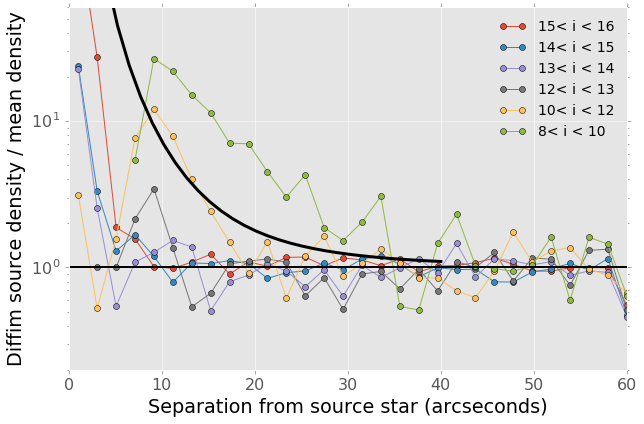

In [5]:

for bin_start,bin_end,curve_values in zip(density_bins[:-1], density_bins[1:], density_curves):
    plt.semilogy(radius_bin_centers, curve_values, 'o-',
             label="{:d}< i < {:d}".format(bin_end, bin_start))

plt.axhline(1, color='k', ls='-', lw=2)
plt.ylim(0.2,60)
plt.xlim(0,60)
plt.xlabel("Separation from source star (arcseconds)")
plt.ylabel("Diffim source density / mean density")
plt.legend(frameon=False, loc="upper right", fontsize=14)
x = np.linspace(4,40,30)
plt.plot(x, 1 + 7*30*30*(x )**-3, 'k-', lw=3)

To fit this set of curves, I need a function for how they scale with source magnitude. I estimate this by plotting the radius at which the dia source density is twice the mean density, for each magnitude bin.

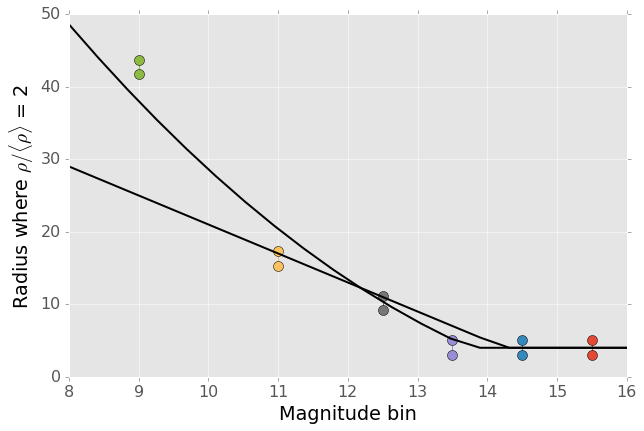

In [6]:
for bin_start,bin_end,curve_values in zip(density_bins[:-1], density_bins[1:], density_curves):
    bin_center = 0.5*(bin_start + bin_end)
    sel_gt_2 = np.where(curve_values > 2)
    sel = np.max(sel_gt_2),(np.max(sel_gt_2)+1)
    bounds_gt_2 = curve_values[np.max(sel_gt_2):(np.max(sel_gt_2)+2)]
    #plt.plot(bin_center + np.zeros(2), bounds_gt_2, 'o-')
    plt.plot(bin_center + np.zeros(2),
             radius_bin_centers[np.max(sel_gt_2):(np.max(sel_gt_2)+2)], 'o-', ms=10)

x = np.linspace(8,16,20)

# Original
plt.plot(x, np.maximum(13-4*(x-12), 4), 'k-', lw=2)

plt.plot(x, np.maximum(11-4*(x-12) + 0.6*(x-14)**2, 4), 'k-', lw=2)

plt.xlim(8,16)
plt.xlabel("Magnitude bin")
plt.ylabel(r"Radius where $\rho/\langle\rho\rangle$ = 2")

This looks ok; a linear scaling with magnitude seems reasonable. Now we can plot one curve for each magnitude bin and the data too.

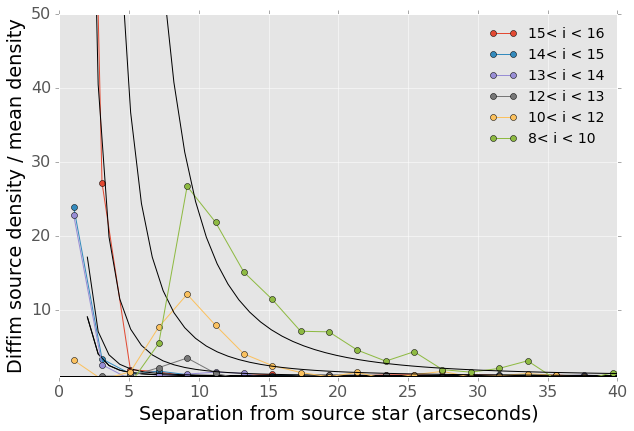

In [7]:
for bin_start,bin_end,curve_values in zip(density_bins[:-1], density_bins[1:], density_curves):
    plt.plot(radius_bin_centers, curve_values, 'o-',
             label="{:d}< i < {:d}".format(bin_end, bin_start))
    mag_bin_center = 0.5*(bin_start + bin_end)
    x = np.linspace(2,40,50)
#    radius_normalization = np.maximum(12-4*(mag_bin_center-12), 4)
    radius_normalization = np.maximum(11-4*(mag_bin_center-12) + 0.2*(mag_bin_center-14)**2, 4)

    plt.plot(x, 1 + (x )**-3.0 / (radius_normalization**-3.0), 'k-', lw=1)

plt.axhline(1, color='k', ls='-', lw=1)
plt.ylim(0.9,50)
plt.xlim(0,40)
plt.xlabel("Separation from source star (arcseconds)")
plt.ylabel("Diffim source density / mean density")
plt.legend(frameon=False, loc="upper right", fontsize=14)


Cumulative distribution
========

This is better behaved than the differential distribution, so this is what we use in the DMTN text.

In [8]:
radius_bins = np.linspace(0,60,60)
radius_bin_centers = 0.5*(radius_bins[1:] + radius_bins[:-1])

# 60 chips. 0.045 sq deg per chip. 3600**2 sq arcsec per sq deg
# 20e3 detections is what I get from counting on visit 197391
mean_density = 0.3*20e3 / (60 * 0.045) / 3600.0**2

# All the good visits happen to be < 197800
good_visits =  (197367, 197375, 197379, 197388, 197392, 197400, 197404, 197412)

#density_bins = [14,12,10,8]
density_bins = np.array([14,13,12,11,10,9,8])
cumulative_curves = []
for bin_start,bin_end in zip(density_bins[:-1], density_bins[1:]):
    filtered_query = session.query(SDC).filter((SDC.visit <= max(good_visits)) &
                                               (SDC.source_mag < bin_start) &
                                               (SDC.source_mag > bin_end))
    H_cumulative = np.zeros(len(radius_bins) - 1)

    for source in filtered_query:
        source_H, _ = np.histogram(source.dist_array(), bins=radius_bins)
        H_cumulative += np.cumsum(source_H)
        
    cumulative_curves.append(H_cumulative/float(filtered_query.count()))

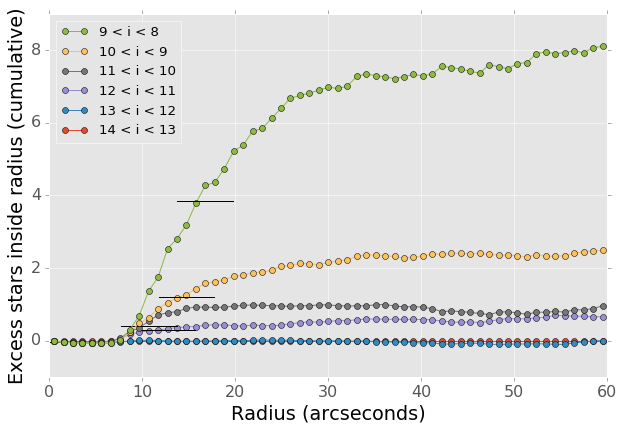

In [9]:
for n,curve in enumerate(cumulative_curves):
    adjusted_curve = curve - cumulative_curves[0]
    outer_value = np.mean(adjusted_curve[int(4/6*len(adjusted_curve)):])
    
    plt.plot(radius_bin_centers, adjusted_curve, '-o',
             label="{:.0f} < i < {:.0f}".format(density_bins[n],density_bins[n+1]))
    sel_cross, = np.where(adjusted_curve > 0.5*outer_value)
    if(len(sel_cross) == 0):
        continue
    cross_80pct = radius_bin_centers[min(sel_cross)] 
    plt.plot(cross_80pct + np.array([-3,3]), 0.5*outer_value + np.zeros(2),'k-')

handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[::-1], labels[::-1], fontsize="small", loc=0)

plt.xlim(xmin=0)
plt.xlabel("Radius (arcseconds)")
plt.ylabel("Excess stars inside radius (cumulative)")

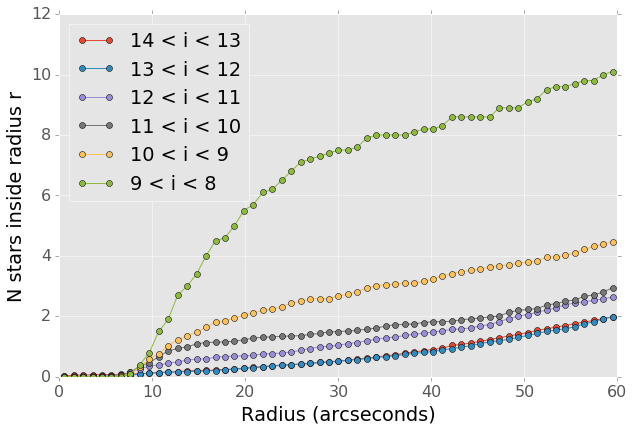

In [10]:
for n,curve in enumerate(cumulative_curves):
    norm = 1
    #norm = 1/curve[len(curve)/2]

    plt.plot(radius_bin_centers, norm*curve, '-o',
             label="{:.0f} < i < {:.0f}".format(density_bins[n],density_bins[n+1]))

plt.legend(loc=0)
plt.xlabel("Radius (arcseconds)")
plt.ylabel("N stars inside radius r")

Modeling Excess Sources
-----------------------

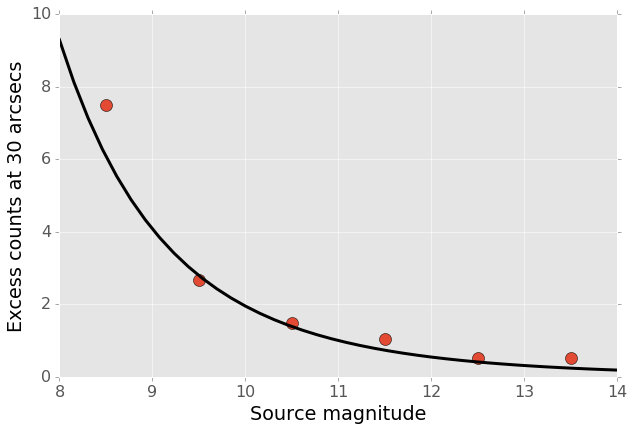

In [11]:
density_bins = np.array([14,13,12,11,10,9,8])
density_bin_centers = 0.5*(density_bins[1:] + density_bins[:-1])
plt.plot(density_bin_centers, [x[int(len(x)/2)] for x in cumulative_curves],'o', ms=12)
#plt.yscale('log')
x = np.linspace(8,14,40)
plt.plot(x, (x/11.0)**-7.0, lw=3, color='k')
plt.xlabel("Source magnitude")
plt.ylabel("Excess counts at 30 arcsecs")

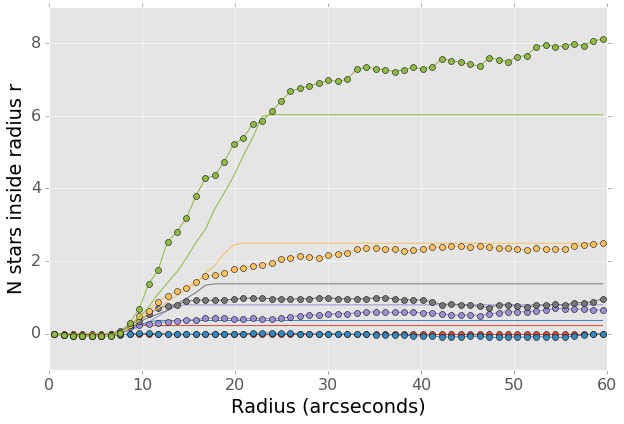

In [12]:
def excess_counts_func(mag):
    return (mag/11.0)**-7.0


for n,(bin_start,bin_end) in enumerate(zip(density_bins[:-1], density_bins[1:])):
    center_mag = 0.5*(bin_start + bin_end)
    target_counts = excess_counts_func(center_mag)
    inner_edge = 8
    outer_edge = 22 - 3.0*(center_mag - 9)
    area = np.pi*(outer_edge**2 - inner_edge**2)
    
    n_iter = 100
    H_cumulative = np.zeros(len(radius_bins) - 1)
    for _ in xrange(n_iter):
        n_sources = np.random.poisson(target_counts/area * (2*outer_edge)**2)
        rand_x = 2*outer_edge*(np.random.rand(n_sources) - 0.5)
        rand_y = 2*outer_edge*(np.random.rand(n_sources) - 0.5)
        rand_r = np.sqrt(rand_x**2 + rand_y**2)
        sel, = np.where((rand_r > inner_edge) & (rand_r < outer_edge))
#        print(target_counts, n_sources, len(sel))
        H,_ = np.histogram(rand_r[sel], bins=radius_bins)
        H_cumulative += np.cumsum(H)
    lines = plt.plot(radius_bin_centers, H_cumulative/float(n_iter), '-')
    
    #
    # Data plot
    adjusted_curve = cumulative_curves[n] - cumulative_curves[0]    
    #plt.plot(outer_edge, target_counts, 'kx')
    plt.plot(radius_bin_centers, adjusted_curve, '-o', color=lines[0].get_color(),
             label="{:.0f} < i < {:.0f}".format(density_bins[n],density_bins[n+1]))

#plt.xlim(5,30)
plt.xlabel("Radius (arcseconds)")
plt.ylabel("N stars inside radius r")    

SNR distribution of DIA sources
=====

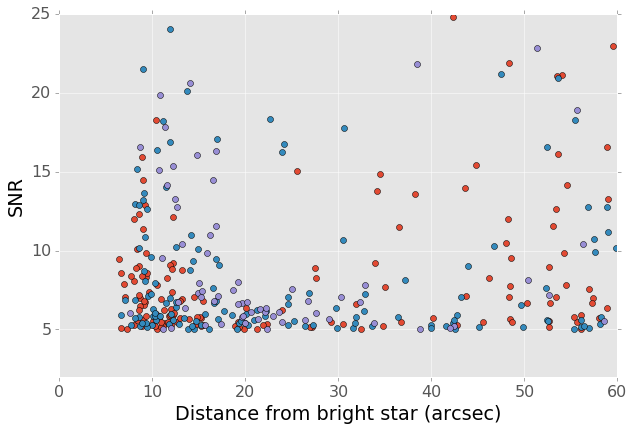

In [13]:
magnitude_bins = np.array([11,10,9,8])

for bin_start,bin_end in zip(magnitude_bins[:-1], magnitude_bins[1:]):
    filtered_query = session.query(SDC).filter((SDC.visit <= max(good_visits)) &
                                               (SDC.source_mag < bin_start) &
                                               (SDC.source_mag > bin_end))
    color = None
    for source in filtered_query:
        lines, = plt.plot(source.dist_array(), source.SNR_array(),'o', color=color)
        color = lines.get_color()

plt.ylim(2,25)
plt.ylabel("SNR")
plt.xlabel("Distance from bright star (arcsec)")

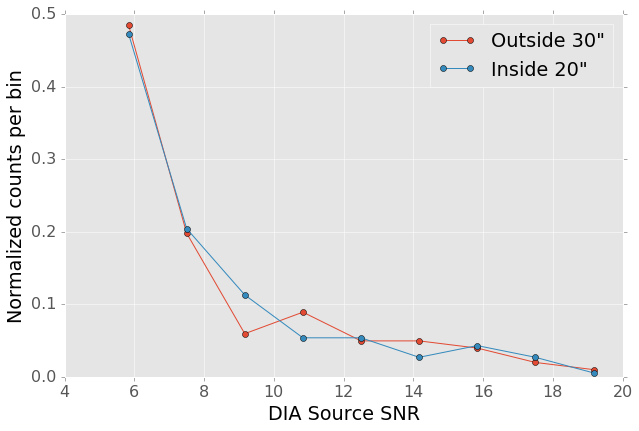

In [14]:
magnitude_bins = np.array([11,10,9,8])

SNR_bins = np.linspace(5,20,10)
H_inside = np.zeros(len(SNR_bins) - 1)
H_outside = np.zeros(len(SNR_bins) - 1)

for bin_start,bin_end in zip(magnitude_bins[:-1], magnitude_bins[1:]):
    filtered_query = session.query(SDC).filter((SDC.visit <= max(good_visits)) &
                                               (SDC.source_mag < bin_start) &
                                               (SDC.source_mag > bin_end))
    color = None
    for source in filtered_query:
        sel_outside, = np.where(source.dist_array() > 30)
        sel_inside, = np.where(source.dist_array() < 20)
        
        H_,_ = np.histogram(source.SNR_array()[sel_outside], bins=SNR_bins)
        H_outside += H_
        
        H_,_ = np.histogram(source.SNR_array()[sel_inside], bins=SNR_bins)
        H_inside += H_
        
SNR_centers = 0.5*(SNR_bins[1:] + SNR_bins[:-1])
plt.plot(SNR_centers, H_outside/float(sum(H_outside)), 'o-', label="Outside 30\"")
plt.plot(SNR_centers, H_inside/float(sum(H_inside)), 'o-', label="Inside 20\"")
plt.legend(loc=0)
plt.xlabel("DIA Source SNR")
plt.ylabel("Normalized counts per bin")